# Paper 

## Simulados

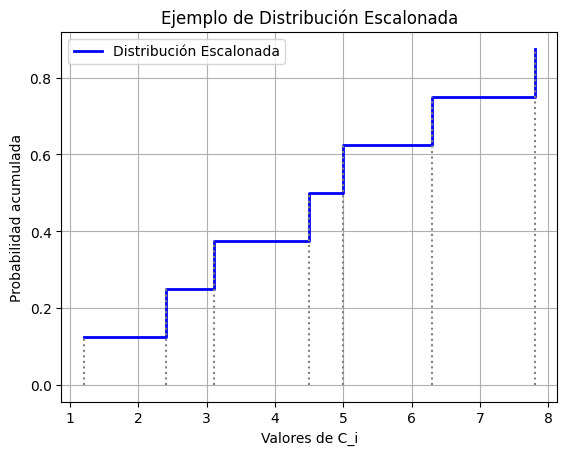

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Valores de C_i ordenados
C_values = np.array([1.2, 2.4, 3.1, 4.5, 5.0, 6.3, 7.8])

# Probabilidades acumuladas P(C ≤ C_i)
n = len(C_values)
probabilities = np.arange(1, n+1) / (n+1)

# Crear la función escalonada
plt.step(C_values, probabilities, where='post', label="Distribución Escalonada", linewidth=2, color='b')

# Agregar líneas verticales para resaltar los escalones
for x, y in zip(C_values, probabilities):
    plt.vlines(x, 0, y, linestyles="dotted", colors='gray')

# Etiquetas y título
plt.xlabel("Valores de C_i")
plt.ylabel("Probabilidad acumulada")
plt.title("Ejemplo de Distribución Escalonada")
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


## Construcción propia

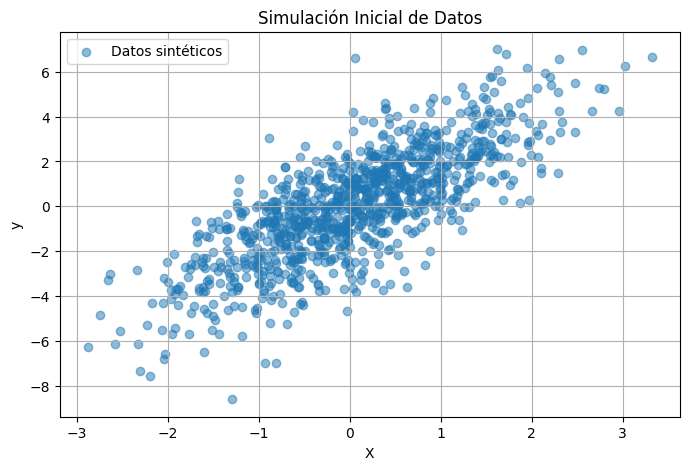

array([1.        , 0.4423028 , 2.28516712])

np.float64(-1.218354501983712)

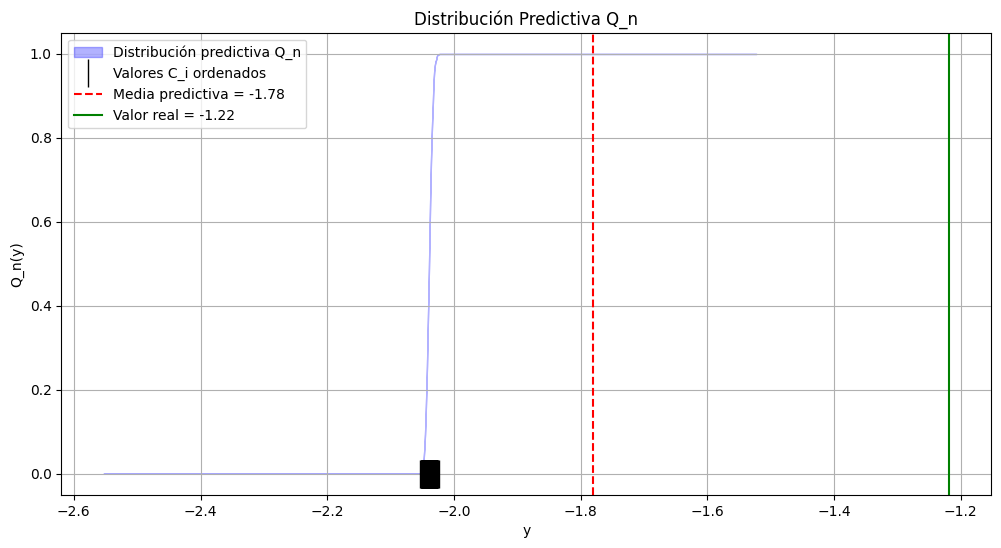

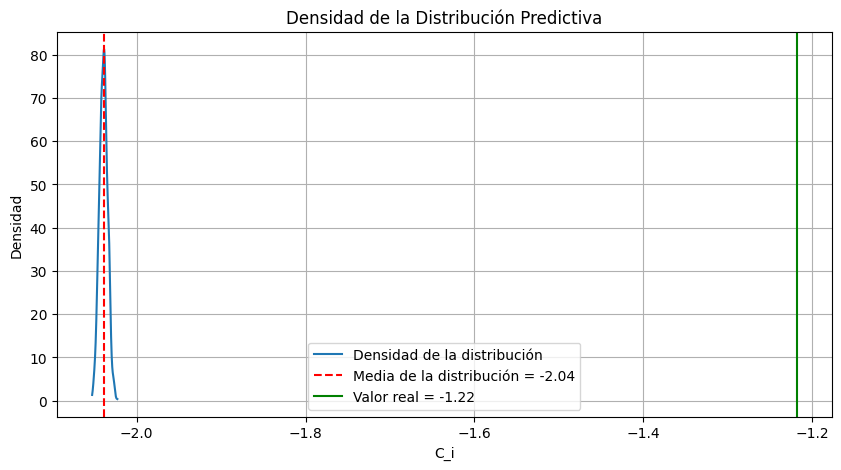

CRPS: 0.8183


np.float64(0.818267520328298)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import inv
from scipy.stats import gaussian_kde
from properscoring import crps_ensemble

def generate_synthetic_data(n, p, mean, seed=42):
    """Genera datos sintéticos para regresión centrados en mean."""
    np.random.seed(seed)
    X = np.hstack((np.ones((n, 1)), np.random.randn(n, p) + mean))
    true_w = np.random.randn(p + 1) + mean
    y = X @ true_w + np.random.randn(n) + mean
    return X, y, true_w

def plot_initial_simulation(X, y):
    """Grafica la simulación inicial."""
    plt.figure(figsize=(8, 5))
    plt.scatter(X[:, 1], y, alpha=0.5, label='Datos sintéticos')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Simulación Inicial de Datos')
    plt.legend()
    plt.grid(True)
    plt.show()

def create_X_bar(X_train, x_test):
    """Crea la matriz extendida X̄."""
    return np.vstack([X_train, x_test.reshape(1, -1)])

def calculate_hat_matrix(X_bar):
    """Calcula la matriz H̄."""
    XTX_inv = inv(X_bar.T @ X_bar)
    return X_bar @ XTX_inv @ X_bar.T

def calculate_C_values(H_bar, y):
    """Calcula los valores C_i."""
    n = len(y)
    h_n = H_bar[n, n]
    sqrt_one_minus_h_n = np.sqrt(1 - h_n)
    
    A = (H_bar[:n, n] @ y) / sqrt_one_minus_h_n
    B = sqrt_one_minus_h_n + H_bar[:n, n] / np.sqrt(1 - np.diag(H_bar[:n, :n]))
    return A / B

def calculate_Q_n(y, C_sorted):
    """Calcula los intervalos de Q_n(y)."""
    n = len(C_sorted)
    idx = np.searchsorted(C_sorted, y)
    if idx == 0:
        return (0, 1/(n+1))
    if idx == n:
        return (n/(n+1), 1)
    return (idx/(n+1), (idx+1)/(n+1))

def calculate_crps(C, y_real):
    """Calcula el Continuous Ranked Probability Score (CRPS) usando la librería properscoring."""
    C_sorted = np.sort(C)
    y_real = np.array([y_real])  # Convertir en array 1D con un solo elemento
    crps_value = crps_ensemble(y_real, C_sorted.reshape(1, -1))
    return crps_value[0]


def plot_density_distribution(C, y_real):
    """Grafica la densidad de la distribución."""
    density = gaussian_kde(C)
    x_vals = np.linspace(min(C), max(C), 1000)
    y_vals = density(x_vals)
    mean_C = np.mean(C)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, label='Densidad de la distribución')
    plt.axvline(mean_C, color='r', linestyle='--', label=f'Media de la distribución = {mean_C:.2f}')
    plt.axvline(y_real, color='g', linestyle='-', label=f'Valor real = {y_real:.2f}')
    plt.xlabel('C_i')
    plt.ylabel('Densidad')
    plt.title('Densidad de la Distribución Predictiva')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictive_distribution(C, y_real, num_points=1000):
    """Grafica la distribución predictiva."""
    C_sorted = np.sort(C)
    y_range = np.linspace(C_sorted[0] - 0.5, C_sorted[-1] + 0.5, num_points)
    intervals = np.array([calculate_Q_n(y, C_sorted) for y in y_range])
    
    lower_bounds, upper_bounds = intervals[:, 0], intervals[:, 1]
    mean_pred = (lower_bounds + upper_bounds) / 2
    weighted_mean = np.sum(y_range * mean_pred) / np.sum(mean_pred)
    
    plt.figure(figsize=(12, 6))
    plt.fill_between(y_range, lower_bounds, upper_bounds, alpha=0.3, color='blue', label='Distribución predictiva Q_n')
    plt.plot(C_sorted, np.zeros_like(C_sorted), 'k|', markersize=20, label='Valores C_i ordenados')
    plt.axvline(x=weighted_mean, color='r', linestyle='--', label=f'Media predictiva = {weighted_mean:.2f}')
    plt.axvline(x=y_real, color='g', linestyle='-', label=f'Valor real = {y_real:.2f}')
    plt.xlabel('y')
    plt.ylabel('Q_n(y)')
    plt.title('Distribución Predictiva Q_n')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    """Ejecuta el flujo completo del modelo."""
    n, p, mean = 1000, 2, 0
    seed = 420
    X, y, true_w = generate_synthetic_data(n, p, mean, seed)
    plot_initial_simulation(X, y)
    
    x_test = np.hstack(([1], np.random.randn(p) + mean))
    y_real = x_test @ true_w + np.random.randn() + mean
    
    display(x_test)
    display(y_real)
    
    X_bar = create_X_bar(X, x_test)
    H_bar = calculate_hat_matrix(X_bar)
    C = calculate_C_values(H_bar, y)
    
    plot_predictive_distribution(C, y_real)
    plot_density_distribution(C, y_real)
    crps = calculate_crps(np.sort(C), y_real)
    print(f"CRPS: {crps:.4f}")
    
    return crps

# Ejecutar ejemplo
main()


## Datos reales

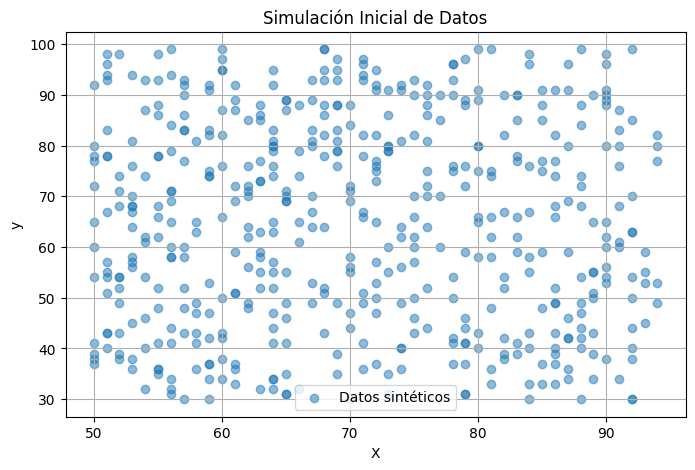

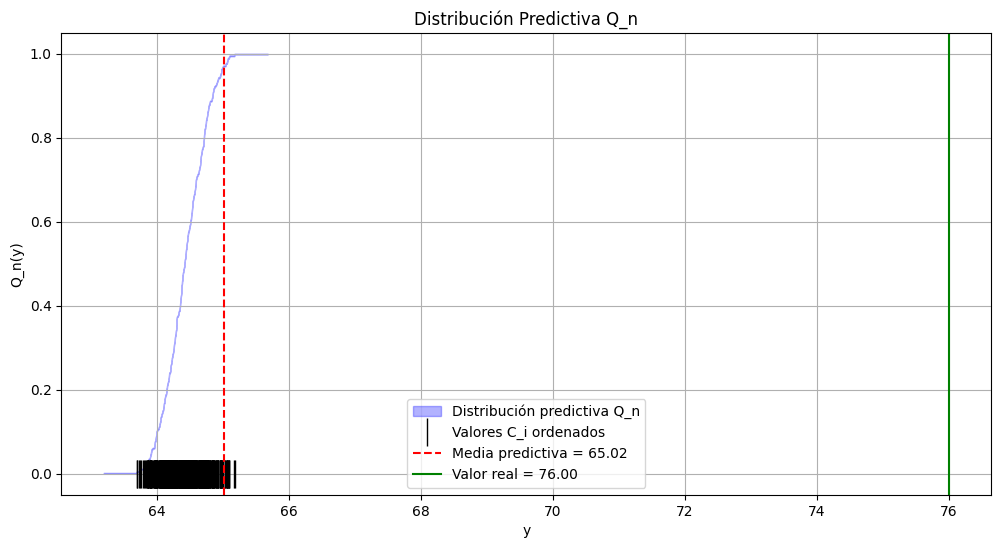

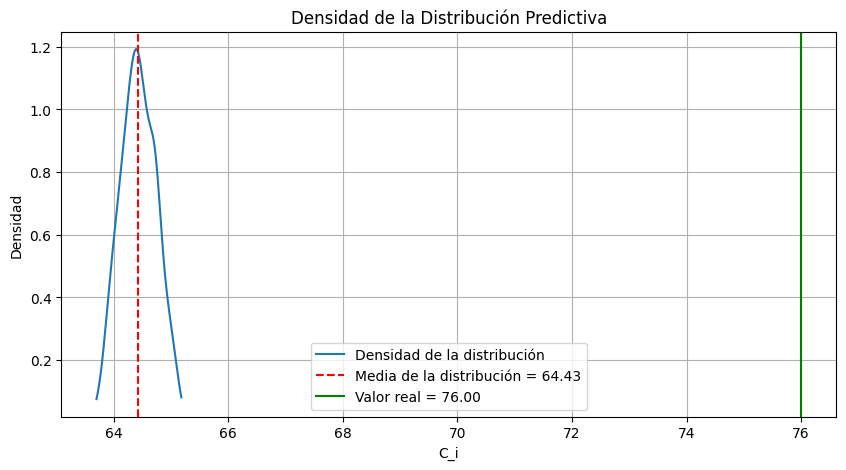

CRPS: 11.3939


np.float64(11.393892083542399)

In [57]:
def load_real_data(csv_path):
    """Carga datos reales desde un archivo CSV y aplica one-hot encoding a variables categóricas."""
    df = pd.read_csv(csv_path)
    # delete all columns that are not numeric
    df = df.select_dtypes(include=[np.number])
    df = df.dropna() 
    # use only the firts 1000 rows
    df = df.head(501)
    X = df.iloc[:, :-1].values  # Todas las columnas excepto la última como características
    y = df.iloc[:, -1].values    # Última columna como variable objetivo
    X = np.hstack((np.ones((X.shape[0], 1)), X))  # Agregar columna de unos para el intercepto
    
    return X, y


def main_data(csv_path):
    """Ejecuta el flujo completo del modelo con datos reales."""
    X, y = load_real_data(csv_path)
    plot_initial_simulation(X, y)
    
    x_test = X[-1]  # Última fila como punto de prueba
    y_real = y[-1]  # Valor real correspondiente
    X = X[:-1]  # Eliminar el último punto de prueba de los datos de entrenamiento
    y = y[:-1]
    
    X_bar = create_X_bar(X, x_test)
    H_bar = calculate_hat_matrix(X_bar)
    C = calculate_C_values(H_bar, y)
    
    plot_predictive_distribution(C, y_real)
    plot_density_distribution(C, y_real)
    crps = calculate_crps(np.sort(C), y_real)
    print(f"CRPS: {crps:.4f}")
    
    return crps

# Ejecutar ejemplo con un archivo CSV
main_data('../../data/alzheimers_prediction_dataset.csv')